## HGT-network-notebook.ipynb by Rohan Maddamsetti

# Fast gene flow network inference from copy number variation in bacterial genomes

The goal of this notebook is to draft matrix and graph visualizations of how identical protein sequences are shared across strains in my dataset.

I will do analyses that focus just on duplicated genes, as well as singleton genes. I will then repeat these analyses, focusing on genes associated with mobile genetic elements.

In order to rapidly estimate distances and cluster genes, I use the MinHash algorithm, as implemented in Erkang Zhu's datasketch package (https://ekzhu.com/datasketch/). Since similar packages are not available in Julia at the moment, I switched to the Python ecosystem).

### List of TODOs:

1) A good heuristic for relatedness is whether two organisms have identical copies of the tuf gene encoding the Tu elongation factor. If two organisms do not share identical tuf sequences, but they have other identical proteins, then it is likely that those identical proteins stem from HGT rather than vertical descent. The same heuristic can be extended to conserved phylogenetic marker genes, etc.

I should apply this heuristic to filter edges in the putative HGT network graph.

2) I should be able to speed up the hierarchical clustering using locality-sensitive hashing. However, this
is not a priority since this doesn't seem to be a speed bottleneck at present.

In [1]:
import pandas as pd
import xxhash
from datasketch import MinHash, LeanMinHash
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from more_itertools import run_length

Let's first look at the duplicate proteins.

In [2]:
dup_protein_fpath = "../results/AR-gene-duplication/duplicate-proteins.csv"
dup_protein_df = pd.read_csv(dup_protein_fpath)

In [3]:
dup_protein_df

,Annotation_Accession,count,chromosome_count,plasmid_count,unassembled_count,product,sequence
0,GCA_003122425.1_ASM312242v1,2,2,0,0,IS110 family transposase,MANSLIFTVMSGVYLMDKTPVGIDIAKLKFDVAVWIERKKYKTKVF...
1,GCA_003122425.1_ASM312242v1,8,8,0,0,transposase,MTYPLKFRQHVLAIKEQEKLTYAQTATRFCIGTASLMRWAKRIEPC...
2,GCA_003122425.1_ASM312242v1,3,3,0,0,hypothetical protein,MSMKLMTHAMSIKVGNPLRKLILLKLADNANDQGECWPSVPYIAHQ...
3,GCA_003122425.1_ASM312242v1,4,4,0,0,ATP-binding protein,MNVIEKIENSRQQQDLTFLEDRLKSARAPLKEIAGVRVDVAEVLCP...
4,GCA_003122425.1_ASM312242v1,4,4,0,0,hypothetical protein,MNEYRIVLPYPPTVNTYWRHARGRHYISKQGRQYRTEVIALIARKG...
...,...,...,...,...,...,...,...
249406,GCA_900087725.2_WHON,2,2,0,0,MafB alternative C terminus,MCEFKDFRRNIPCFEEYDENSFIGKWYDDGVWDDEEYWKLENALIE...
249407,GCA_900087725.2_WHON,2,2,0,0,MafA-like protein,MKTLLLLIPLVLTACGTLTGIPAHGGGKRFAVEQELVAASSRAAVK...
249408,GCA_900087725.2_WHON,2,2,0,0,pilS cassette,MNPSGVNKEIQDKRLSLWAKRENGSVKWFCGQPVKRDNANAAKDDV...
249409,GCA_900087725.2_WHON,2,2,0,0,fimbrial protein,MAEGQKSAVTEYYLNNGKWPKNNTSAGVASPPSDIKGKYVQSVTVA...


In [4]:
def ProteinToAccession(protein_df):
    """make a dictionary of protein sequence to Annotation_Accession."""
    protseq_to_accession = dict()

    for _, row in protein_df.iterrows():
        accession = row['Annotation_Accession']
        seq = row['sequence']
        
        if seq in protseq_to_accession:
            protseq_to_accession[seq].append(accession)
        else:
            protseq_to_accession[seq] = [accession]

    return protseq_to_accession

In [5]:
def SharedProteinToAccession(protseq_to_accession):
    """filter for sequences that are present in multiple genomes."""
    return {seq:acc_vec for seq, acc_vec in protseq_to_accession.items() if len(acc_vec) > 1}

In [6]:
def AccessionToProtein(protein_df):
    """ make a dictionary of Annotation_Accession to protein sequence."""
    accession_to_protseq = dict()
    
    for _, row in protein_df.iterrows():
        accession = row['Annotation_Accession']
        seq = row['sequence']
        
        if accession in accession_to_protseq:
            accession_to_protseq[accession].append(seq)
        else:
            accession_to_protseq[accession] = [seq]
    
    return accession_to_protseq

In [7]:
def FilterAccessionToProteinDictForSharedSequences(accession_to_protseq, HGT_protseq_to_accession):
    """filter for sequences that are present in multiple genomes."""  
    filtered_accession_to_protseq = dict()
        
    for accession, protvec in accession_to_protseq.items():
        for prot in protvec:
            if prot in HGT_protseq_to_accession:
                filtered_accession_to_protseq[accession] = protvec
    
    return filtered_accession_to_protseq

In [8]:
## Make a dictionary of protein sequence to Annotation_Accession.
prot_to_accession = ProteinToAccession(dup_protein_df)
HGT_dup_protseq_to_accession = SharedProteinToAccession(prot_to_accession)

In [9]:
HGT_dup_protein_df = dup_protein_df[dup_protein_df.apply(lambda row: row['sequence'] in HGT_dup_protseq_to_accession, axis=1)]

In [10]:
HGT_dup_protein_df

,Annotation_Accession,count,chromosome_count,plasmid_count,unassembled_count,product,sequence
92,GCA_000648515.1_ASM64851v1,2,1,1,0,reverse transcriptase,MIISEMQRKLATWAATDPSLRIQRLLRLITQPEWLAEAARITLSSK...
93,GCA_000648515.1_ASM64851v1,5,5,0,0,transposase,MSGKRYPEEFKIEAVKQVVDRGYSVASVATRLDITTHSLYAWIKKY...
94,GCA_000648515.1_ASM64851v1,9,1,8,0,transposase,MNPFKGRHFQRDIILWAVRWYCKYGISYRELQEMLAERGVNVDHST...
95,GCA_000648515.1_ASM64851v1,3,3,0,0,transposase,MLDVHPSGFYAWLQQPHSQRHQADLRLTGQIKQFWLESGCVYGYRK...
96,GCA_000648515.1_ASM64851v1,2,2,0,0,transposase,MPGNRPHYGRWPQHDFPPFKKLRPQSVTSRIQPGSDVIVCAEMDEQ...
...,...,...,...,...,...,...,...
249404,GCA_900087725.2_WHON,4,4,0,0,ComE1,MKKMFVLFCMLFSCAFSLAAVNINAASQQELEALPGIGPAKAKAIA...
249405,GCA_900087725.2_WHON,2,2,0,0,MafB alternative C terminus,MCEFKDIIRNVPYFEGYDENSFIGKWYDDGVWDDEEYWKLENDLIE...
249406,GCA_900087725.2_WHON,2,2,0,0,MafB alternative C terminus,MCEFKDFRRNIPCFEEYDENSFIGKWYDDGVWDDEEYWKLENALIE...
249407,GCA_900087725.2_WHON,2,2,0,0,MafA-like protein,MKTLLLLIPLVLTACGTLTGIPAHGGGKRFAVEQELVAASSRAAVK...


In [11]:
## make a dictionary of Annotation_Accession to protein sequence.
HGT_dup_accession_to_protseq = AccessionToProtein(HGT_dup_protein_df)

In [12]:
def minhash(seq_list, num_perm=512):
    """ calculate the minhash of an arbitrary sequence of strings with this function.
    comes from the tutorial at: https://skeptric.com/minhash/
    """
    m = MinHash(num_perm=num_perm, hashfunc=xxhash.xxh64_intdigest)
    for seq in seq_list:
        m.update(seq.encode('utf8'))
    return LeanMinHash(m)

In [13]:
def ClusterSymmetricGenomeMatrix(accession_to_seqhashvec):
    """ cluster genomes using MinHash. 
    See: https://ekzhu.com/datasketch/minhash.html and the tutorial at: https://skeptric.com/minhash/
    """
    
    ## make MinHash objects corresponding to each genome.
    GenomeToMinHashDict = {acc_id : minhash(seqhashvec) for acc_id, seqhashvec in accession_to_seqhashvec.items()}

    ## use minhash to calculate jaccard distance/similarity across strains, as before.
    acc_id_vec = [x for x in GenomeToMinHashDict.keys()]
    num_genomes = len(GenomeToMinHashDict.keys())
    genome_distance_matrix = np.zeros((num_genomes, num_genomes))

    ## make a Jaccard distance matrix for the genomes.
    for (i,x) in enumerate(acc_id_vec):
        for (j,y) in enumerate(acc_id_vec):
            if i <= j: continue ## skip the lower triangular entries and the diagonal.
            MinHash_i = GenomeToMinHashDict[x]
            MinHash_j = GenomeToMinHashDict[y]
            genome_distance_matrix[i,j] = 1 - MinHash_i.jaccard(MinHash_j)

    ## we want the full matrix later as well, for sorting and plotting with matplotlib imshow().
    full_genome_distance_matrix = genome_distance_matrix + np.transpose(genome_distance_matrix)
        
    ## convert to a scipy condensed distance matrix from a square symmetric distance matrix.
    genome_condensed_distance_matrix = squareform(full_genome_distance_matrix)

    ## now, cluster the genomes by similarity, then sort the matrix.
    genome_clustering = linkage(genome_condensed_distance_matrix, 'average', optimal_ordering = True)
    genome_dendrogram_index = leaves_list(genome_clustering)    

    ## sort the accessions by the clustering.
    sorted_acc_id_vec = [acc_id_vec[i] for i in genome_dendrogram_index]

    ## sort the distance matrix
    sorted_genome_distance_matrix = full_genome_distance_matrix[:,:]
    ## sort the rows.
    sorted_genome_distance_matrix = sorted_genome_distance_matrix[genome_dendrogram_index,:]
    ## sort the columns.
    sorted_genome_distance_matrix = sorted_genome_distance_matrix[:,genome_dendrogram_index]

    ## turn into into a Jaccard similarity matrix (1 - Jaccard distance)
    sorted_genome_similarity_matrix = np.ones((num_genomes, num_genomes)) - sorted_genome_distance_matrix

    ## return the tuple of the sorted accession_ids (the labels for each of the rows/cols)
    ## and the sorted genome similarity matrix itself.
    return (sorted_acc_id_vec, sorted_genome_similarity_matrix)

In [14]:
HGT_dup_acc_id_vec, HGT_dup_genome_similarity_matrix = ClusterSymmetricGenomeMatrix(HGT_dup_accession_to_protseq)

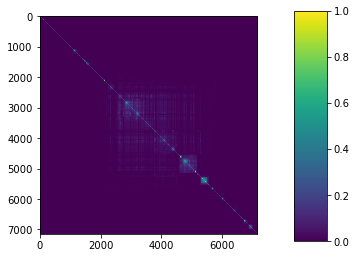

In [15]:
plt.imshow(HGT_dup_genome_similarity_matrix)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

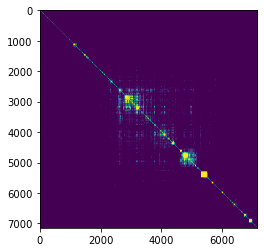

In [45]:
num_dup_genomes = len(HGT_dup_acc_id_vec)
binary_HGT_dup_genome_similarity_matrix = np.zeros((num_dup_genomes, num_dup_genomes))
for i in range(num_dup_genomes):
    for j in range(num_dup_genomes):
        if HGT_dup_genome_similarity_matrix[i,j] > 0.1:
            binary_HGT_dup_genome_similarity_matrix[i,j] = 1

plt.imshow(binary_HGT_dup_genome_similarity_matrix)

In [17]:
def SingletonSeqHashToAccession(all_protein_fpath):
    """make a dictionary of xxhashes of protein sequences to Annotation_Accession."""
    protseqhash_to_accession = dict()

    with open(all_protein_fpath, "r") as all_protein_fh:
        for i, line in enumerate(all_protein_fh):
            if i == 0: continue
            fields = line.split(',')
            ## IMPORTANT: every element of fields is a string!
            acc_id, count, chr_count, plasmid_count, unassembled_count, prot_annotation, seq = fields
            count = int(count) ## so, we have to turn count into an int for the next comparison.
            if count != 1: continue ## only consider singletons-- skip the rest.
        
            seqhash = xxhash.xxh64(seq).hexdigest()
            if seqhash in protseqhash_to_accession:
                protseqhash_to_accession[seqhash].append(acc_id)
            else:
                protseqhash_to_accession[seqhash] = [acc_id]

    return protseqhash_to_accession

In [18]:
## for comparison, let's look at singletons.
all_protein_fpath = "../results/AR-gene-duplication/all-proteins.csv"
## filter for singletons present in multiple genomes.
shared_protseqhash_to_accession = SharedProteinToAccession(SingletonSeqHashToAccession(all_protein_fpath))

In [19]:
def AccessionToSharedSingletonSeqHash(all_protein_fpath, shared_protseq_hash_to_accession):
    """ make a dictionary of Annotation_Accession to protein sequence xxhashes.
        Sequences are filtered based on occurrence in the keys of shared_protseq_hash_to_accession."""
    accession_to_shared_protseqhash = dict()
    
    with open(all_protein_fpath, "r") as all_protein_fh:
        for i, line in enumerate(all_protein_fh):
            if i == 0: continue
            fields = line.split(',')
            ## IMPORTANT: every element of fields is a string!
            acc_id, count, chr_count, plasmid_count, unassembled_count, prot_annotation, seq = fields
            count = int(count) ## so, we have to turn count into an int for the next comparison.
            if count != 1: continue ## only consider singletons-- skip the rest.
            
            seqhash = xxhash.xxh64(seq).hexdigest()
            if seqhash in shared_protseq_hash_to_accession:
                if acc_id in accession_to_shared_protseqhash:
                    accession_to_shared_protseqhash[acc_id].append(seqhash)
                else:
                    accession_to_shared_protseqhash[acc_id] = [seqhash]     
    return accession_to_shared_protseqhash 

In [20]:
## now, go back, and filter the original singleton protein sequence data,
## based on the sequences found in multiple genomes.
accession_to_shared_singleton_seqhash = AccessionToSharedSingletonSeqHash(all_protein_fpath, shared_protseqhash_to_accession)

In [21]:
shared_singleton_acc_id_vec, shared_singleton_genome_similarity_matrix = ClusterSymmetricGenomeMatrix(accession_to_shared_singleton_seqhash)

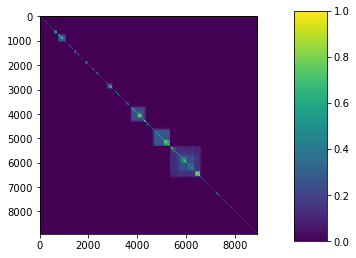

In [22]:
plt.imshow(shared_singleton_genome_similarity_matrix)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

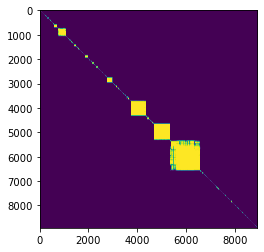

In [46]:
num_singleton_genomes = len(shared_singleton_acc_id_vec)
binary_singleton_genome_similarity_matrix = np.zeros((num_singleton_genomes, num_singleton_genomes))
for i in range(num_singleton_genomes):
    for j in range(num_singleton_genomes):
        if shared_singleton_genome_similarity_matrix[i,j] > 0.1:
            binary_singleton_genome_similarity_matrix[i,j] = 1

plt.imshow(binary_singleton_genome_similarity_matrix)

In [47]:
## get the common set of genomes found in both the duplication and singleton matrices, for comparisons.
intersection_genomes = set(shared_singleton_acc_id_vec).intersection(set(HGT_dup_acc_id_vec))

In [48]:
len(intersection_genomes)

7136

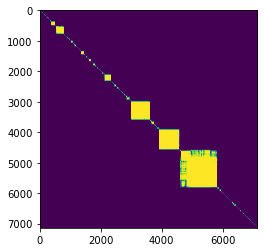

In [49]:
## filter the singleton matrix plot to genomes that have HGT_duplications.
singleton_indices_in_dup_matrix = [i for i,x in enumerate(shared_singleton_acc_id_vec) if x in intersection_genomes]

filtered_singleton_acc_id_vec = [x for x in shared_singleton_acc_id_vec if x in intersection_genomes]

filtered_binary_singleton_matrix = binary_singleton_genome_similarity_matrix[:,:]
filtered_binary_singleton_matrix = filtered_binary_singleton_matrix[singleton_indices_in_dup_matrix,:]
filtered_binary_singleton_matrix = filtered_binary_singleton_matrix[:,singleton_indices_in_dup_matrix]
plt.imshow(filtered_binary_singleton_matrix)

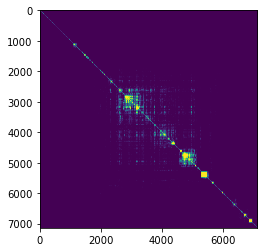

In [50]:
dup_indices_in_singleton_matrix = [i for i,x in enumerate(HGT_dup_acc_id_vec) if x in intersection_genomes]

filtered_HGT_dup_acc_id_vec = [x for x in HGT_dup_acc_id_vec if x in intersection_genomes]

filtered_binary_HGT_dup_matrix = binary_HGT_dup_genome_similarity_matrix[:,:]
filtered_binary_HGT_dup_matrix = filtered_binary_HGT_dup_matrix[dup_indices_in_singleton_matrix,:]
filtered_binary_HGT_dup_matrix = filtered_binary_HGT_dup_matrix[:,dup_indices_in_singleton_matrix]
plt.imshow(filtered_binary_HGT_dup_matrix)

## compare the duplicate/singleton matrices for the same genomes, using the matrix ordering for singletons, and the matrix ordering for duplicates.

In [51]:
## make dictionaries of accession to row/col indices for the singleton and duplicate clustered matrices.
filtered_singleton_acc_to_index_dict = {x:i for i,x in enumerate(filtered_singleton_acc_id_vec)}
filtered_HGT_dup_acc_to_index_dict = {x:i for i,x in enumerate(filtered_HGT_dup_acc_id_vec)}

filtered_singleton_order_for_dup_mat = [filtered_singleton_acc_to_index_dict[x] for x in filtered_HGT_dup_acc_id_vec]
dup_order_for_filtered_singleton_mat = [filtered_HGT_dup_acc_to_index_dict[y] for y in filtered_singleton_acc_id_vec]

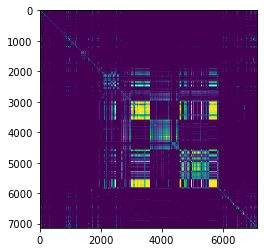

In [52]:
dup_ordered_binary_singleton_matrix = filtered_binary_singleton_matrix[:,:]
dup_ordered_binary_singleton_matrix = dup_ordered_binary_singleton_matrix[dup_order_for_filtered_singleton_mat,:]
dup_ordered_binary_singleton_matrix = dup_ordered_binary_singleton_matrix[:,dup_order_for_filtered_singleton_mat]
plt.imshow(dup_ordered_binary_singleton_matrix)

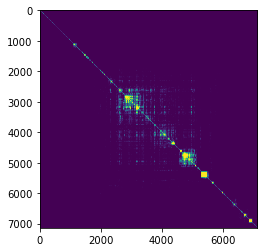

In [57]:
plt.imshow(filtered_binary_HGT_dup_matrix)

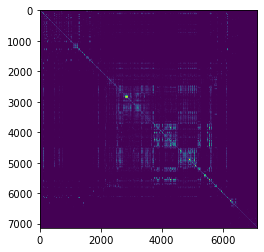

In [53]:
singleton_ordered_binary_dup_matrix = filtered_binary_HGT_dup_matrix[:,:]
singleton_ordered_binary_dup_matrix = singleton_ordered_binary_dup_matrix[filtered_singleton_order_for_dup_mat,:]
singleton_ordered_binary_dup_matrix = singleton_ordered_binary_dup_matrix[:,filtered_singleton_order_for_dup_mat]
plt.imshow(singleton_ordered_binary_dup_matrix)

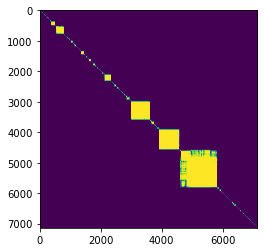

In [55]:
plt.imshow(filtered_binary_singleton_matrix)

### Question: 
how well does unsupervised clustering by duplication
recover environmental labels? how does this compare to clustering by
singletons?

### Answer:
both approaches perform similarly, but clustering by singletons does a bit better.

I compare vector of ecology labels to the vector of singleton ordering and the vector of duplication ordering. Use run-length encoding of the labels, ordered by the singleton ordering and ordered by the duplicate ordering. if duplicate ordering better captures ecology, then its code for the labels should have a better compression factor (less entropy/less mixing of the labels on the axis).

This idea didn't work! At face value, looks like duplications don't provide more information about ecology than singletons (although they don't do so bad).

In [31]:
## get the ecology annotation.
annotation_fpath = "../results/AR-gene-duplication/computationally-annotated-gbk-annotation-table.csv"
annotation_df = pd.read_csv(annotation_fpath)

In [32]:
annotation_df

,Annotation_Accession,host,isolation_source,Annotation
0,GCA_003122425.1_ASM312242v1,Acyrthosiphon pisum,cell culture,Animal-host
1,GCA_000648515.1_ASM64851v1,NaN,sink aerator,Anthropogenic-environment
2,GCA_014170115.1_ASM1417011v1,NaN,Cow rumen,Livestock
3,GCA_001077675.1_ASM107767v1,Homo sapiens,NaN,Human-host
4,GCA_002850015.1_ASM285001v1,NaN,olive fermentation,Food
...,...,...,...,...
10037,GCA_000264455.2_ASM26445v2,NaN,NaN,NaN
10038,GCA_003491205.1_ASM349120v1,NaN,ENVO:00002006,Freshwater
10039,GCA_001806345.1_ASM180634v1,Homo sapiens,Bronchial,Human-host
10040,GCA_000015225.1_ASM1522v1,NaN,NaN,NaN


In [33]:
## make a dictionary of annotation_accession to annotation.
acc_id_to_annotation = {row['Annotation_Accession'] : row['Annotation'] for _, row in annotation_df.iterrows()}

## order annotations by singleton genome order
filtered_singleton_order_annotations = [acc_id_to_annotation[x] for x in filtered_singleton_acc_id_vec if type(acc_id_to_annotation[x]) == str]

## order annotations by HGT dup genome order
filtered_HGT_dup_order_annotations = [acc_id_to_annotation[x] for x in filtered_HGT_dup_acc_id_vec if type(acc_id_to_annotation[x]) == str]


In [40]:
len(list(run_length.encode(filtered_singleton_order_annotations)))

1995

In [39]:
len(list(run_length.encode(filtered_HGT_dup_order_annotations)))

2121

In [54]:
(2121-1995)/2121

0.0594059405940594

In [42]:
filtered_singleton_order_annotations

['Soil',
 'Food',
 'Food',
 'Marine',
 'Freshwater',
 'Freshwater',
 'Freshwater',
 'Freshwater',
 'Marine',
 'Terrestrial',
 'Freshwater',
 'Soil',
 'Freshwater',
 'Plant-host',
 'Plant-host',
 'Plant-host',
 'Plant-host',
 'Plant-host',
 'Freshwater',
 'Freshwater',
 'Freshwater',
 'Marine',
 'Freshwater',
 'Freshwater',
 'Freshwater',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Plant-host',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Plant-host',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Soil',
 'Anthropogenic-environment',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Animal-host',
 'Animal-host',
 'Food',
 'Livestock',
 'Human-host',
 'Livestock',
 'Livestock',
 'Human-host',
 'Animal-host',
 'Human-host',
 'Livestock',
 'Sediment',
 'Food',
 'Food',
 'Human-host',
 'Human-host'

In [41]:
filtered_HGT_dup_order_annotations

['Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Soil',
 'Freshwater',
 'Soil',
 'Soil',
 'Terrestrial',
 'Anthropogenic-environment',
 'Sediment',
 'Anthropogenic-environment',
 'Sediment',
 'Marine',
 'Animal-host',
 'Animal-host',
 'Animal-host',
 'Animal-host',
 'Animal-host',
 'Sediment',
 'Terrestrial',
 'Human-host',
 'Human-host',
 'Human-host',
 'Human-host',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Plant-host',
 'Agriculture',
 'Agriculture',
 'Plant-host',
 'Agriculture',
 'Agriculture',
 'Agriculture',
 'Agricultu

idea to try: use locality-sensitive hashing to impute missing ecology annotations. Use LSH/nearest labeled neighbor to impute. Can test using known labels that are "masked" for the purposes of testing. This is useful from a bioinformatician perspective, less so from a biologist perspective (the person isolating the samples and doing the sequencing).